In [1]:
import scipy as sp
import scipy.integrate as spint8
import os,sys
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen; from GWGen import WFGenerator
import pyAnalyticFluxes as pyan
from GWGen.WFGenerator import *
from few.utils.utility import get_separatrix
from few.trajectory.inspiral import EMRIInspiral
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyAnalyticFluxes as pyan
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# set initial parameters
M = 200000
m = 1e1
mu = 1e-16
a = 0.6
p0 = 10.47
e0 = 0.7
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.8
qK = 0.2
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 10.0

alphaval = alphavalue(M,mu)
print(r"alpha = {0}".format(alphaval))


use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "npoints": 100,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "dense_output":False
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

traj = PNTraj()
pc =ProcaSolution(M,a,mu)
    
deltaC = pc.ChangeInOrbitalConstants(SecondaryMass=m, SMBHMass=M)
few_traj = EMRIInspiral(func="pn5")

def IncreaseArrayDensity(arr, npoints):
    assert len(arr)<=npoints, "Error: npoints must be equal to or larger than length of input array"
    if npoints>len(arr):
        newarr = [arr[0]]
        remainder = npoints*len(arr)
        for inx, i in enumerate(arr):
            if inx<len(arr)-1:
                newintpnts = int(floor(npoints/len(arr)))+1
                newsec = np.linspace(arr[inx], arr[inx+1], newintpnts)[1:]
                _=[newarr.append(i) for i in newsec]
        remainderpoints=npoints-len(newarr)
        arrend = newarr[-remainderpoints:]
        arrendavgs = 1/2*(np.array(arrend)[1:] + np.array(arrend)[:-1])
        newarrend = []
        for i in range(len(arrend) + len(arrendavgs)):
            if i%2 == 0:
                newarrend.append(arrend[int(i/2)])
            if i%2 == 1:
                newarrend.append(arrendavgs[int((i-1)/2)])
        newarr = newarr[:-remainderpoints-1]
        _=[newarr.append(i) for i in newarrend]
        return newarr
    elif npoints==len(arr):
        return arr

alpha = 0.14966276123144448
UltralightBoson instance not provided. Instantiating class...
done.


Error at parameter point (p,e)=(4.047040708394928,0.18137506440327894). 
	 SystemError: <built-in function pyKerrGeoCoordinateFrequencies> returned a result with an error set
Error at parameter point (p,e)=(4.053387689649798,0.18170626332555898). 
	 SystemError: <built-in function pyKerrGeoCoordinateFrequencies> returned a result with an error set
Error at parameter point (p,e)=(4.042715553822991,0.1811779410938026). 
	 SystemError: <built-in function pyKerrGeoCoordinateFrequencies> returned a result with an error set
Error at parameter point (p,e)=(4.04704099881826,0.18137506865118153). 
	 SystemError: <built-in function pyKerrGeoCoordinateFrequencies> returned a result with an error set
Error at parameter point (p,e)=(4.053387974099409,0.181706267275067). 
	 SystemError: <built-in function pyKerrGeoCoordinateFrequencies> returned a result with an error set
Error at parameter point (p,e)=(4.042715832194244,0.18117794472156273). 
	 SystemError: <built-in function pyKerrGeoCoordinateFre

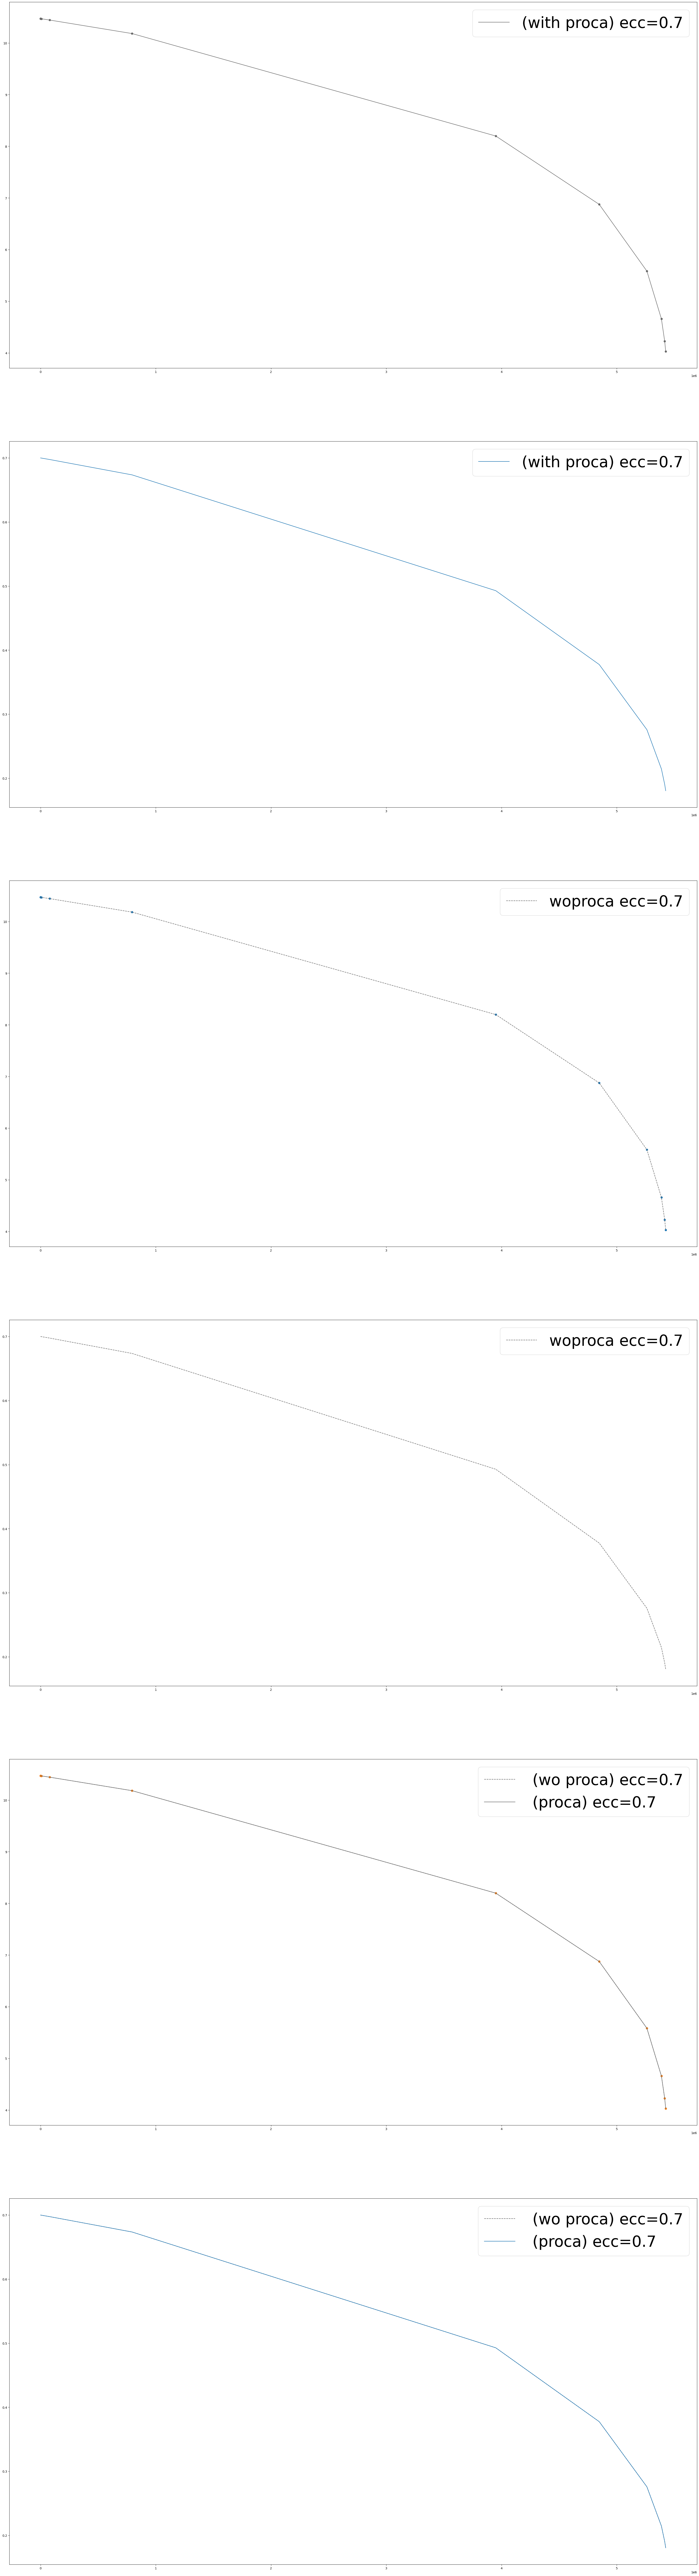

In [3]:
inspiral_kwargs["dense_output"]=False
traj.separatrix_cutoff = get_separatrix(a,e0,1.)+0.01
fig,axes = plt.subplots(6,1,figsize=(40,150))
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.CSS4_COLORS.items())
cols = [name for hsv, name in by_hsv]

inx=1
ec = e0
#few
fewres = traj(M,m,a,p0,ec,Y0,T=T,**inspiral_kwargs)
axes[2].plot(fewres[0], fewres[1], label="woproca ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[2].scatter(fewres[0], fewres[1])
axes[2].legend(fontsize=50)
axes[3].plot(fewres[0], fewres[2], label="woproca ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[3].legend(fontsize=50)

#mine
res = traj(M,m,a,p0,ec,Y0,T=T, DeltaEFlux = deltaC["E"], DeltaLFlux = deltaC["L"], **inspiral_kwargs)
print("exit reason {0}    last p {1}".format(traj.exit_reason, res[1][-1]))
t,p,e = res[0:3]
axes[0].plot(t,p,label="(with proca) ecc={0}".format(ec),color=cols[inx])
axes[0].scatter(t,p,color=cols[inx])
axes[1].plot(t,e,label="(with proca) ecc={0}".format(ec))
axes[0].legend(labelcolor="Black",fontsize=50)
axes[1].legend(fontsize=50)

axes[4].plot(fewres[0], fewres[1], label=" (wo proca) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[4].plot(t,p,label=" (proca) ecc={0}".format(ec),color=cols[inx])
axes[4].scatter(t,p)
axes[4].scatter(fewres[0], fewres[1])
axes[5].plot(fewres[0], fewres[2], label=" (wo proca) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
axes[5].plot(t,e,label=" (proca) ecc={0}".format(ec))
axes[4].legend(fontsize=50)
axes[5].legend(fontsize=50);

resfalse = res
fewresfalse = fewres

len(fewrestrue) = 15
len(fewresfalse) = 15


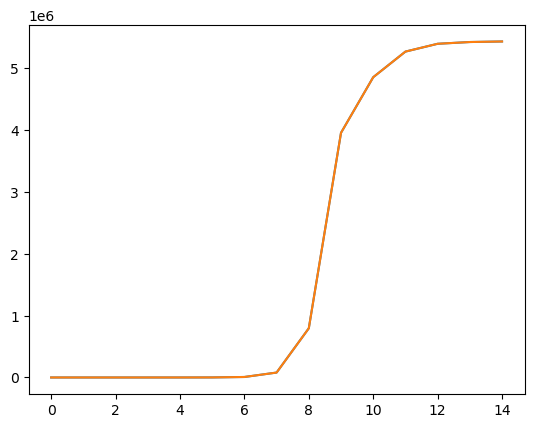

In [4]:
print("len(fewrestrue) = {0}".format(len(fewrestrue[0])))
print("len(fewresfalse) = {0}".format(len(fewresfalse[0])))
plt.plot(fewresfalse[0])
plt.plot(fewrestrue[0])

len(restrue) = 15
len(resfalse) = 15


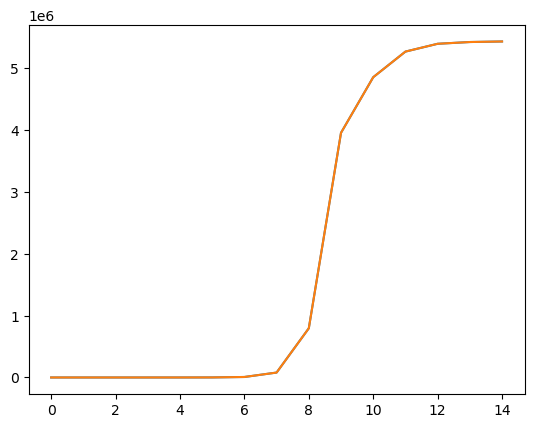

In [5]:
print("len(restrue) = {0}".format(len(restrue[0])))
print("len(resfalse) = {0}".format(len(resfalse[0])))
plt.plot(resfalse[0])
plt.plot(restrue[0])

In [2]:
e0=0.2
p0=10
y0=[p0,e0,0,0,0]
npoints=100

fun = PN(M,m, DeltaEFlux = deltaC["E"], DeltaLFlux = deltaC["L"])
t_start = 0
t_stop = 11* YRSID_SI / (M * MTSUN_SI)
t_res = t_stop/npoints
t_span = (t_start, t_stop)
t_dom = np.arange(t_start, t_stop, t_res)
max_step_size = t_span[-1]/npoints
init_sep = get_separatrix(0.9,e0,1.)
fun.separatrix_cutoff = get_separatrix(a,e0,1.)+0.1

class event_holder:
    pass
holder = event_holder()
holder.exit_reason=None

def __integration_event_tracker_eccentricity(_, y_vec):
    ecc = y_vec[1]
    #define a function which is has a zero at e=1, a zero at the smallest negative float, and positive on the range [0,1)
    eps = np.finfo(float).eps
    x_shift = (1-eps**2)/(2*(eps+1))
    y_shift = (eps+x_shift)**2
    res = y_shift - (ecc-x_shift)**2
    #if res<=0:
      #  holder.exit_reason = "Eccentricity exceeded bounds"
    return 1

def __integration_event_tracker_semilatus_rectum(_, y_vec):
    p = y_vec[0]
    res = p-fun.separatrix_cutoff
    if res<=0:
        holder.exit_reason = "Separatrix reached!"
    return res

def __integration_event_tracker_pFlux(_, y_vec):
    Eflux =fun.UndressedpFlux(y_vec[1],y_vec[0])
    res = -Eflux
    if res<=0:
        holder.exit_reason="PN p flux larger than zero! Breaking."
    return res
def __integration_event_tracker_eFlux(_, y_vec):
    p,e = y_vec[:2]
    if e<10**(-10):
        Lflux=0
    else:
        Lflux = fun.UndressedeFlux(e,p)
    res = -Lflux
    if res<0:
        holder.exit_reason="PN e flux larger than zero! Breaking."
    if e==0:
        return np.finfo(float).eps
    return res

__integration_event_tracker_eccentricity.terminal=True
__integration_event_tracker_semilatus_rectum.terminal=True
__integration_event_tracker_pFlux.terminal=True
__integration_event_tracker_eFlux.terminal=True

__integration_event_trackers = [__integration_event_tracker_eccentricity,
                                                        __integration_event_tracker_semilatus_rectum,
                                                        __integration_event_tracker_pFlux]

aa=time.time()
res=solve_ivp(fun, t_span, y0, method="DOP853",events = __integration_event_trackers)
bb = time.time()
res2 = GWGen.Utils.HelperFunctions.solve_ivp(fun, t_span, y0, method="DOP853",events = __integration_event_trackers)
cc=time.time()
restime = bb-aa
res2time = cc-bb
t = res["t"]
p,e,phiphi,phitheta,phir = res["y"]
x=np.ones_like(p)

In [7]:
M = 1e5
m = 1e1
a = 0.9
p0 = 10.0
e0 = 0.3
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2

inspiralkwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "npoints":100,
    "dense_output":True
}

# keyword arguments for summation generator (AAKSummation)
sumkwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

MYwfgen = EMRIWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)
PROCAwfgen = EMRIWithProcaWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)

/mnt/Data_Volume/Computer_Programs/Anaconda/envs/few_env/lib/python3.7/site-packages/few/summation/aakwave.py:228: UserWarning: Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6.
  "Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6."


UltralightBoson instance not provided. Instantiating class...
done.


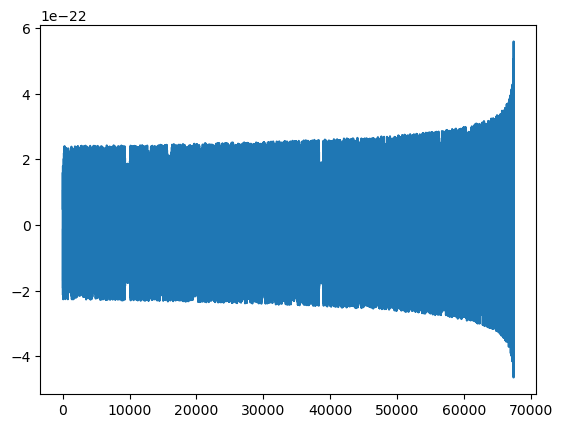

In [8]:
wv = MYwfgen(M,m,a,p0,e0,1.,qS,phiS,qK,phiK,dist,T=5)
wvp = PROCAwfgen(M,m,mu, a,p0,e0,1.,qS=qS,phiS=phiS,qK=qK,phiK=phiK,dist=dist,T=T, dt=dt)
plt.plot(wv.real)

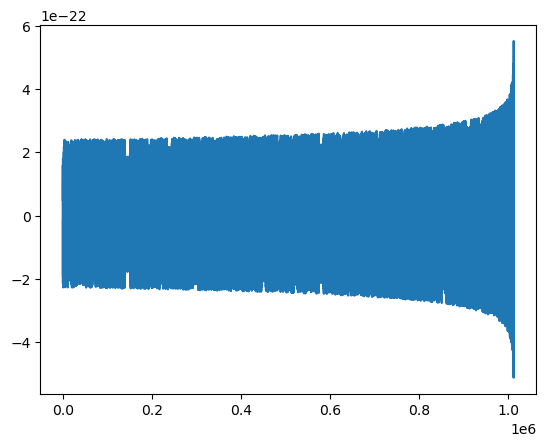

In [9]:
plt.plot(np.arange(len(wvp))*dt,wvp.real)

In [1]:
import os,sys
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen; from GWGen import WFGenerator; from GWGen.Utils import *
import matplotlib.pyplot as plt

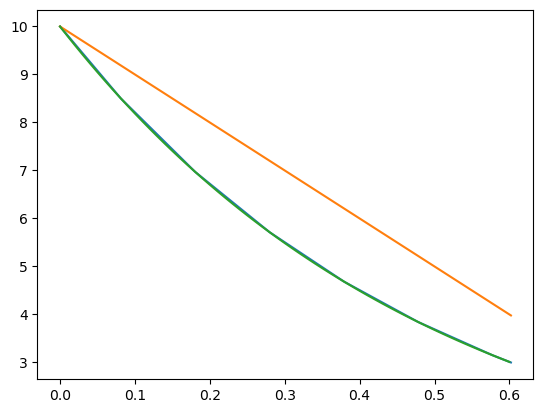

In [16]:
def fun(t,x):
    if x[0]<2:
        return None
    else:
        return np.asarray([-2*x[0],-10])
def event1(_,y):
    return y[1]
def event2(_,y):
    return y[0]-3
event2.terminal=True
event1.terminal=True
res=solve_ivp(fun, (0,4), [10,10],dense_output=True,events=[event1,event2])
plt.plot(res["t"], res["y"][0])
plt.plot(res["t"], res["y"][1])
plt.plot(np.arange(res["t"][0], res["t"][-1], 0.01), res["sol"](np.arange(res["t"][0], res["t"][-1], 0.01))[0])

In [19]:
td=IncreaseArrayDensity(res["t"],100)

In [20]:
res["sol"](td)

array([[10.        ,  9.86553407,  9.73287619,  9.6020021 ,  9.47288786,
         9.34550982,  9.21984463,  9.09586926,  8.97356096,  8.8528973 ,
         8.73385614,  8.61641565,  8.50055429,  8.36093841,  8.22361546,
         8.08854795,  7.95569891,  7.82503196,  7.69651125,  7.57010153,
         7.44576807,  7.32347672,  7.2031939 ,  7.08488656,  6.96852224,
         6.85406895,  6.74149536,  6.6307707 ,  6.52186469,  6.41474748,
         6.30938972,  6.20576248,  6.10383731,  6.0035862 ,  5.90498163,
         5.8079965 ,  5.71260421,  5.61904171,  5.5270115 ,  5.43648857,
         5.34744831,  5.25986645,  5.17371912,  5.08898281,  5.00563438,
         4.92365107,  4.84301047,  4.76369058,  4.68566975,  4.60892664,
         4.53344037,  4.45919043,  4.38615661,  4.31431904,  4.24365811,
         4.17415454,  4.10578936,  4.03854389,  3.97239977,  3.90733893,
         3.84334363,  3.78039274,  3.71847287,  3.6575672 ,  3.59765914,
         3.53873239,  3.48077087,  3.42375877,  3.3